In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap

c:\Users\schni\OneDrive\Documents\Switzerland\Bottmedical\.venv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\schni\OneDrive\Documents\Switzerland\Bottmedical\.venv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\schni\OneDrive\Documents\

In [2]:
# Import the batch file

batch_path = os.path.join(os.getcwd(), "Batch_runs_convolution")
file_path = os.path.join(batch_path, "Default_batch_5.csv")
try_batch = pd.read_csv(file_path)
try_batch = try_batch.iloc[:,1:]

In [3]:
# Separate each run into a separate df

grouped = try_batch.groupby('RunId')
batch_by_runs = {name: group for name, group in grouped}    

In [31]:
# Create a dataframe that summarizes all iterations of the batch run with inital conditions and final classification of the iteration

batch_summary = pd.Series()

for category, frame in batch_by_runs.items():
    initial_conditions = frame.loc[:,["RunId", "num_type_a_1", "num_type_a_2", "is_torus", "grid_height", "grid_width", "immediate_killing", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A1_Initial_Aggressiveness", "A2_Initial_Competition_Index"]].iloc[0]

    n_predator = frame.loc[:, "A1_Number"]
    n_prey = frame.loc[:, "A2_Number"]

    n_steps = pd.Series(frame.loc[:, "Step"].iloc[-1], index=["Steps_Number"])

    n_predator_final = n_predator.iloc[-1]
    n_prey_final = n_prey.iloc[-1]

    predator_slope = abs(n_predator_final - n_predator.iloc[100]) / 500
    prey_slope = abs(n_prey_final - n_prey.iloc[100]) / 500

    #Determine the final state. Steady state is assigned if the slope on the last 500 simualtion steps is less then 0.05
    if n_predator_final == 0 and n_prey_final == 0:
        final_state = pd.Series("No bacteria survival", index=["Final_State"])
    elif n_predator_final != 0 and n_prey_final == 0:
        final_state = pd.Series("Predator domination", index=["Final_State"])
    elif n_predator_final == 0 and n_prey_final != 0:
        final_state = pd.Series("Prey domination", index=["Final_State"])
    elif n_predator_final > n_prey_final:
        if predator_slope < 0.075 and prey_slope < 0.075:
            final_state = pd.Series("Steady state, predator domination", index=["Final_State"])
        else:
            final_state = pd.Series("Predator domination", index=["Final_State"])
    elif n_prey_final >= n_predator_final:
        if predator_slope < 0.075 and prey_slope < 0.75:
            final_state = pd.Series("Steady state, prey domination", index=["Final_State"])
        else:
            final_state = pd.Series("Prey domination", index=["Final_State"])

    time_steps = range(151)

    # plt.plot(time_steps, n_predator, label = "Predator")
    # plt.plot(time_steps, n_prey, label = "Prey")
    # plt.legend()
    # plt.xlabel('Time Step')
    # plt.ylabel('Number of Agents')
    # print(initial_conditions.loc["RunId"],final_state)
    # plt.show()

    n_predator_final = pd.Series(n_predator_final, index=["A1_Final_Count"])
    n_prey_final = pd.Series(n_prey_final, index=["A2_Final_Count"])

    predator_slope = pd.Series(predator_slope, index=["A1_Slope"])
    prey_slope = pd.Series(prey_slope, index=["A2_Slope"])

    iteration_summary = pd.concat([final_state, initial_conditions, n_steps, n_predator_final, n_prey_final, predator_slope, prey_slope], axis = 0)
    batch_summary =  pd.concat([batch_summary, iteration_summary], axis = 1)

batch_summary = batch_summary.T
batch_summary = batch_summary.iloc[1:,:]
batch_summary.set_index('RunId', inplace=True)


In [32]:
# Get the summary of our variable of interest

batch_summary.Final_State.value_counts()

Final_State
Predator domination                  1373
Steady state, prey domination         141
Steady state, predator domination      95
Prey domination                        11
Name: count, dtype: int64

In [38]:
batch_summary.columns

Index(['Final_State', 'num_type_a_1', 'num_type_a_2', 'is_torus',
       'grid_height', 'grid_width', 'immediate_killing', 'aggressiveness',
       'avrg_viability_time_type_a', 'A1_Initial_Edge_Distance',
       'A2_Initial_Edge_Distance', 'A1_Initial_Aggressiveness',
       'A2_Initial_Competition_Index', 'Steps_Number', 'A1_Final_Count',
       'A2_Final_Count', 'A1_Slope', 'A2_Slope', 'Predator_vs_Prey'],
      dtype='object')

In [ ]:
# Preprocess the batch summary

batch_summary["Predator_vs_Prey"] = batch_summary.loc[:, "num_type_a_1"]/batch_summary.loc[:, "num_type_a_2"]
batch_summary_preprocessed = batch_summary.loc[:,["Predator_vs_Prey", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A1_Initial_Aggressiveness", "A2_Initial_Competition_Index", "A1_Final_Count", "A2_Final_Count"]]


In [34]:
# UMAP implementation

reducer = umap.UMAP(random_state = 10)

# Standadize and scale the data and reduce the dimensions

batch_summary_umap_scaled = StandardScaler().fit_transform(batch_summary_preprocessed)
embedding = reducer.fit_transform(batch_summary_umap_scaled)
embedding.shape

(1620, 2)

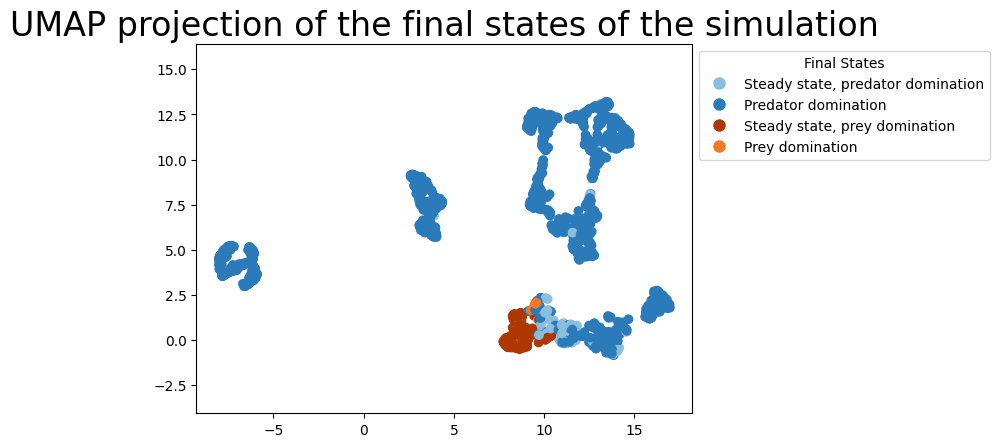

In [35]:
# Plot the UMAP

custom_palette = [
    # sns.color_palette("pastel")[4],   # Pastel Purple
    sns.color_palette("Blues")[2],    # Darker Blue
    # sns.color_palette("Blues")[3],    # Medium Blue
    sns.color_palette("Blues")[4],    # Lighter Blue
    sns.color_palette("Oranges")[5],  # Darker Orange
    # sns.color_palette("Oranges")[4],  # Medium Orange
    sns.color_palette("Oranges")[3],  # Lighter Orange
]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[custom_palette[x] for x in batch_summary.Final_State.map(
        {#"No bacteria survival": 0,
        "Steady state, predator domination": 0,
        # "Pseudo-steady state, predator domination": 2, 
        "Predator domination": 1,
        "Steady state, prey domination": 2,
        # "Pseudo-steady state, prey domination": 5,
        "Prey domination": 3,
        }
        )])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the final states of the simulation', fontsize=24)

# Create a legend
legend_labels = {
    # 0: "No bacteria survival",
    0: "Steady state, predator domination",
    # 2: "Pseudo-steady state, predator domination",
    1: "Predator domination",
    2: "Steady state, prey domination",
    # 5: "Pseudo-steady state, prey domination",
    3: "Prey domination",
}

# Create a list of Patch objects to use for the legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[x], markersize=10, label=label) for x, label in legend_labels.items()]

# Add the legend to the plot
plt.legend(handles=legend_patches, title="Final States", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
for umap_x in range(embedding.shape[1]):

    for feature in batch_summary_umap.keys():

        plt.scatter(
            embedding[:, umap_x],
            batch_summary_umap.loc[:, feature],
            c=[custom_palette[x] for x in batch_summary.Final_State.map(
                {"No bacteria survival": 0,
                "Steady state, predator domination": 1,
                "Pseudo-steady state, predator domination": 2, 
                "Predator domination": 3,
                "Steady state, prey domination": 4,
                "Pseudo-steady state, prey domination": 5,
                "Prey domination": 6,
                }
                )])
    
        plt.ylabel(f"{feature}")
        plt.xlabel(f"UMAP {umap_x+1}")


        # Create a legend
        # legend_labels = {
        #     0: "No bacteria survival",
        #     1: "Steady state, predator domination",
        #     2: "Pseudo-steady state, predator domination",
        #     3: "Predator domination",
        #     4: "Steady state, prey domination",
        #     5: "Pseudo-steady state, prey domination",
        #     6: "Prey domination",
        # }

        # # Create a list of Patch objects to use for the legend
        # legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[x], markersize=10, label=label) for x, label in legend_labels.items()]

        # # Add the legend to the plot
        # plt.legend(handles=legend_patches, title="Final States", bbox_to_anchor=(1, 1))
        plt.show()

In [36]:
# Function to play around with UMAP parameters
c = [custom_palette[x] for x in batch_summary.Final_State.map(
        {#"No bacteria survival": 0,
        "Steady state, predator domination": 0,
        # "Pseudo-steady state, predator domination": 2, 
        "Predator domination": 1,
        "Steady state, prey domination": 2,
        # "Pseudo-steady state, prey domination": 5,
        "Prey domination": 3,
        }
        )]

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(random_state = 10,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(batch_summary_umap_scaled)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c = c)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c = c)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c = c, s=100)
    plt.title(title, fontsize=18)

c:\Users\schni\OneDrive\Documents\Switzerland\Bottmedical\.venv\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\schni\OneDrive\Documents\Switzerland\Bottmedical\.venv\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


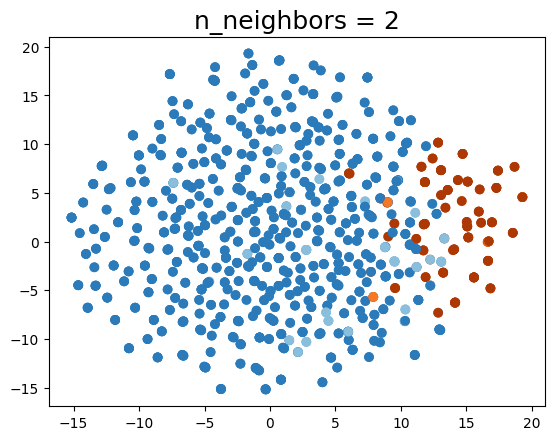

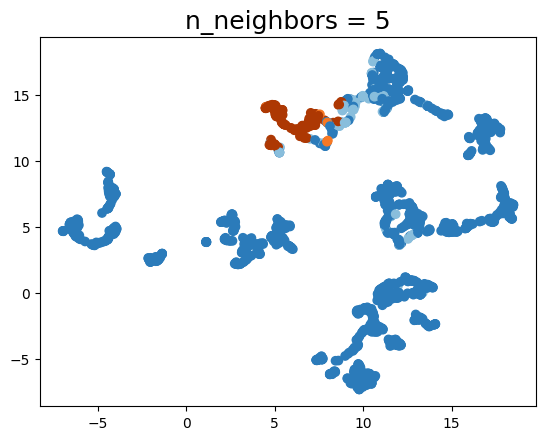

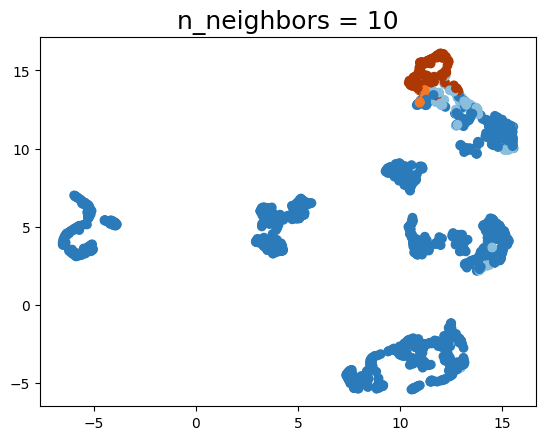

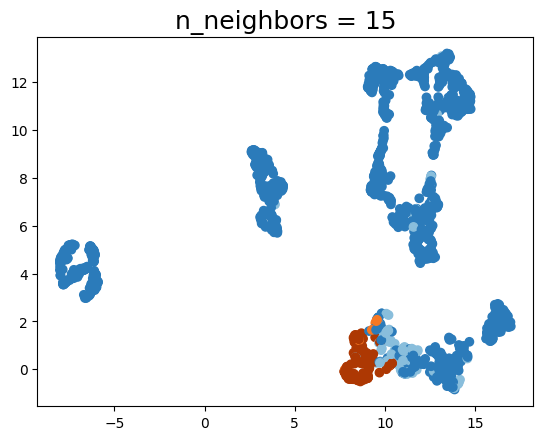

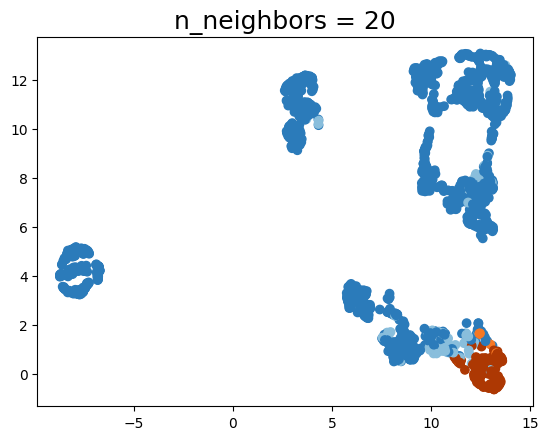

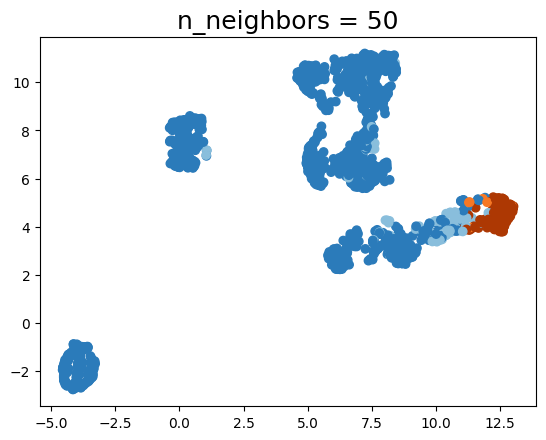

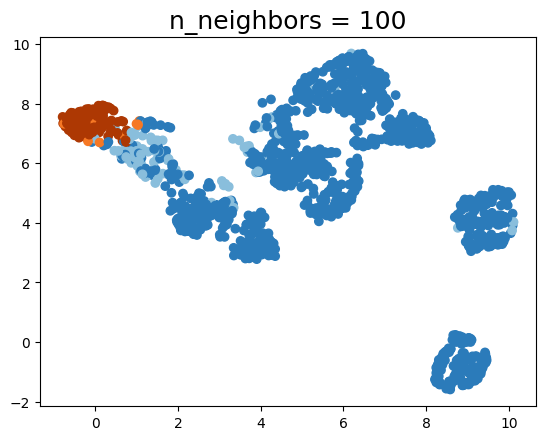

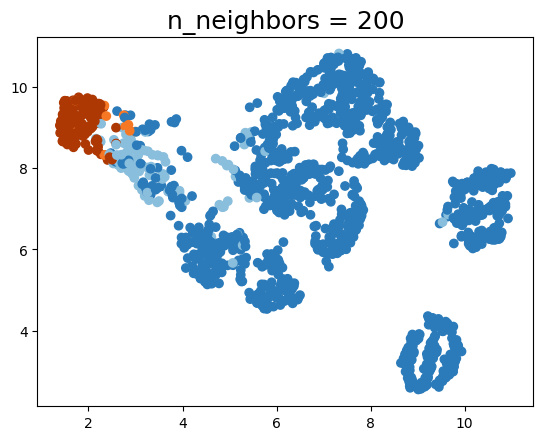

In [37]:
# Change number of neighbors: increaing the parameter brings the objects together till they start to separate again

for n in (2, 5, 10, 15, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))